# Inference from data using different Bayesian Belief Network (BBN) Structures

This notebook shows how to apply different BBN structures to the same parameters. The parameters, means and covariances, are estimated from data generated from linear equations. Approximate inference is the performed on each BBN to observed the associated parameters.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from pybbn.lg.graph import Dag, Parameters, Bbn

np.random.seed(37)

There are four variables, x0, x1, x2, and x4. 

In [2]:
num_samples = 10000

x0 = 2.0 + np.random.standard_normal(num_samples)
x1 = 5.0 + 2.0 * x0 + np.random.standard_normal(num_samples)
x2 = 2.0 + np.random.standard_normal(num_samples)
x3 = 1.0 + 0.3 * x1 + 0.5 * x2 + np.random.standard_normal(num_samples)
x4 = 8.0 + 0.9 * x3 + np.random.standard_normal(num_samples)

df = pd.DataFrame({
    'x0': x0,
    'x1': x1,
    'x2': x2,
    'x3': x3,
    'x4': x4})

means = np.array(df.mean())
cov = np.array(df.cov().values)

Model 1's structure represents the true model's structure. The structures of Models 2, 3, and 4 are made-up ones. We perform approximate inference for each BBN and observe how the estimated parameters associated with the BBN compare to the parameters associated with the linear equations.

In [3]:
max_samples = 9000
max_iters = 1

# create the directed acylic graph
# this is based on the true structure 
dag1 = Dag()
dag1.add_node(0)
dag1.add_node(1)
dag1.add_node(2)
dag1.add_node(3)
dag1.add_node(4)
dag1.add_edge(0, 1)
dag1.add_edge(1, 3)
dag1.add_edge(2, 3)
dag1.add_edge(3, 4)

# The parameters are estimated from the samples above
params = Parameters(means, cov)

# create the bayesian belief network
bbn1 = Bbn(dag1, params, max_samples=max_samples, max_iters=max_iters, mb=True)

In [4]:
# create the directed acylic graph
# this is based on an imposed structure
dag2 = Dag()
dag2.add_node(0)
dag2.add_node(1)
dag2.add_node(2)
dag2.add_node(3)
dag2.add_node(4)
dag2.add_edge(0, 1)
dag2.add_edge(1, 3)
dag2.add_edge(1, 4)
dag2.add_edge(2, 3)

# create the bayesian belief network
bbn2 = Bbn(dag2, params, max_samples=max_samples, max_iters=max_iters, mb=True)

In [5]:
# create the directed acylic graph
# this is based on an imposed structure
dag3 = Dag()
dag3.add_node(0)
dag3.add_node(1)
dag3.add_node(2)
dag3.add_node(3)
dag3.add_node(4)
dag3.add_edge(0, 1)
dag3.add_edge(1, 3)
dag3.add_edge(3, 4)
dag3.add_edge(3, 2)

# create the bayesian belief network
bbn3 = Bbn(dag3, params, max_samples=max_samples, max_iters=max_iters, mb=True)

In [6]:
dag4 = Dag()
dag4.add_node(0)
dag4.add_node(1)
dag4.add_node(2)
dag4.add_node(3)
dag4.add_node(4)
dag4.add_edge(0, 1)
dag4.add_edge(2, 3)
dag4.add_edge(3, 4)

# create the bayesian belief network
bbn4 = Bbn(dag4, params, max_samples=max_samples, max_iters=max_iters, mb=True)

Do some approximate inference and observe how the estimated parameters compare to the empirical ones. Note that `x1` has `x0` as a parent, `x3` as a child, and `x2` as a coparent and so its [Markov blanket](https://en.wikipedia.org/wiki/Markov_blanket) is `x0, x3, x2`. If we condition on the Markov blanket of `x1`, then we know all we need to know to estimate the state of `x1`. In the approximate inference algorithm we are using, [Gibbs sampling](https://en.wikipedia.org/wiki/Gibbs_sampling), we only sample `x0` based on its Markov blanket as defined by the structure of the BBN. Since Model 1's structure represents the true relationships between all the variables, we expect that the parameter estimation from it would be closest to the empirical one. 

* Empirical mean of `x1` is 8.99
* Estimated mean of `x1` with Model 1 is 8.75
* Estimated mean of `x1` with Model 2 is 8.06
* Estimated mean of `x1` with Model 3 is 9.34
* Estimated mean of `x1` with Model 4 is 9.98

In [7]:
print(means)
print(bbn1.do_inference())
print(bbn2.do_inference())
print(bbn3.do_inference())
print(bbn4.do_inference())

[ 2.00172341  8.99427581  2.00498856  4.68968355 12.23579291]
[ 1.72899076  8.25867383  2.89240628  4.78425396 13.39843849]
[ 2.12550081  8.94781937  1.59195174  4.96596736 13.1227521 ]
[ 1.98599524  9.34236961  2.18319841  4.67423445 12.08305803]
[ 2.41020049  9.97740736  0.19535363  3.6934995  10.71940168]


Note that if we do approximate inference again, we get different results.

In [8]:
print(means)
print(bbn1.do_inference())
print(bbn2.do_inference())
print(bbn3.do_inference())
print(bbn4.do_inference())

[ 2.00172341  8.99427581  2.00498856  4.68968355 12.23579291]
[ 2.13357044  9.61769632  1.55537494  5.14578291 12.41618957]
[ 2.24569154  9.87532434  1.75630482  4.42269733 13.20841394]
[ 2.64495122  9.72837857  2.28219061  4.48637915 12.20904582]
[ 2.54737054 10.48950134  3.18097493  6.13233732 12.82671239]


Look at the log likelihood of the data given the models. As you can see, log likelihood of the data given model 1 is the highest.

In [9]:
data_mat = df.values
logp1 = bbn1.log_prob(data_mat)
logp2 = bbn2.log_prob(data_mat)
logp3 = bbn3.log_prob(data_mat)
logp4 = bbn4.log_prob(data_mat)

print('log prob of model 1 {}'.format(logp1))
print('log prob of model 2 {}'.format(logp2))
print('log prob of model 3 {}'.format(logp3))
print('log prob of model 4 {}'.format(logp4))

log prob of model 1 -30845.8806963
log prob of model 2 -32812.7333249
log prob of model 3 -31073.604703
log prob of model 4 -31768.1770266


Here's the plots of the four models.

Text(0.5,1,'Model 4')

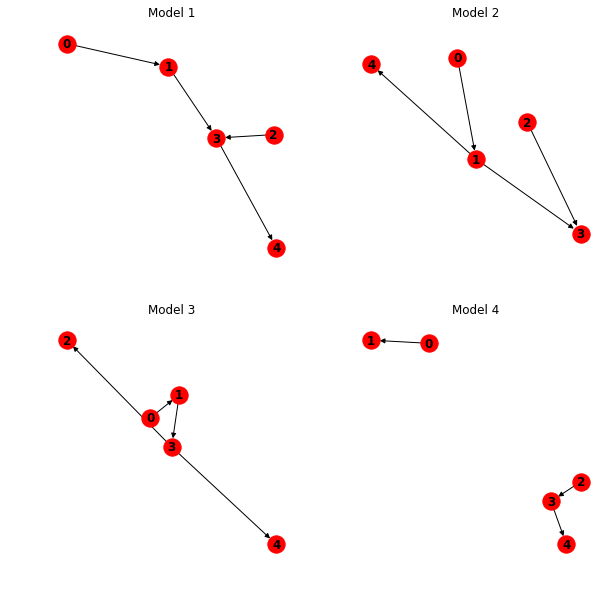

In [10]:
plt.figure(figsize=(10, 10))
plt.subplot(221) 
nx.draw(bbn1.dag.g,with_labels=True, font_weight='bold')
plt.title('Model 1')
plt.subplot(222) 
nx.draw(bbn2.dag.g,with_labels=True, font_weight='bold')
plt.title('Model 2')
plt.subplot(223) 
nx.draw(bbn3.dag.g,with_labels=True, font_weight='bold')
plt.title('Model 3')
plt.subplot(224) 
nx.draw(bbn4.dag.g,with_labels=True, font_weight='bold')
plt.title('Model 4')